In [1]:
# Imports

import sys
sys.path.append("../")
import numpy
import matplotlib
from tensorflow import keras
#from classes import ModelWrapper, DataLoader, Cluster, getTotalNonlinearityResiduum, fitLinePCA, removeChimneys, Plotting, LinearFit

from classes.modelWrapperClass import ModelWrapper
from classes.dataLoaderClass import DataLoader
from classes.linearFitClass import LinearFit
from classes.plottingClass import Plotting
from classes.clusterClass import Cluster

#Interactive matplotlib plots
%matplotlib widget

2024-10-15 08:17:42.890442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Initialisation

modelAPI = ModelWrapper(keras.models.load_model("./models/3D/M1", compile=False))
#modelAPI.model.summary()
data_loader = DataLoader("./data")

noisy = data_loader.getBatch(experimental=True, noisy=True, preprocessed=True)
noisy_with_E = data_loader.getBatch(experimental=True, noisy=True, preprocessed=False)
clean = data_loader.getBatch(experimental=True, noisy=False, preprocessed=True)
names = data_loader.getX17Names()

X17_noisy = data_loader.getBatch(True, True, preprocessed=True)[100:]	# Events 0-100 are used for event generator calibration and other stuff, so these are excluded from validation data
X17_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[100:]
X17_nonNN = data_loader.getBatch(True,False)[100:]
X17_names = data_loader.getX17Names()[100:]
X17_reconstructions = modelAPI.evaluateBatch(X17_noisy) #* X17_noisy

calib_noisy = data_loader.getBatch(True, True, preprocessed=True)[:100]
calib_noisy_with_E = data_loader.getBatch(True, True, preprocessed=False)[:100]
calib_nonNN = data_loader.getBatch(True,False)[:100]
calib_names = data_loader.getX17Names()[:100]
calib_reconstructions = modelAPI.evaluateBatch(calib_noisy)

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')

def upsample(event):
	return numpy.repeat(numpy.repeat(event, 10, axis=0), 10, axis=1)[:100,:120,:200]	# for accurate visualisation

2024-10-15 08:17:56.055753: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


4/4 [==============================] - 1s 106ms/step


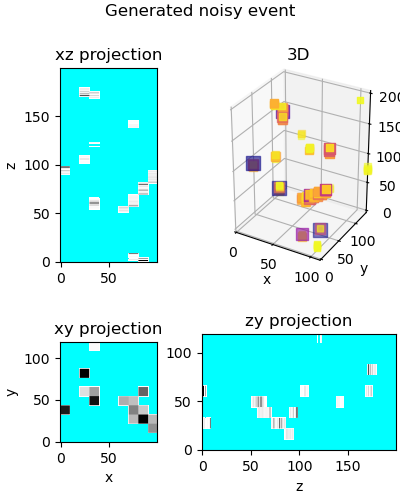

In [3]:
# View generated data
is_noisy = True

events = data_loader.getBatch(False, is_noisy, 0, preprocessed=False)
index = numpy.random.randint(0, events.shape[0])

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot2DAnd3D(events[index], "Generated noisy event")
fig.set_size_inches(4,5)
matplotlib.pyplot.show()

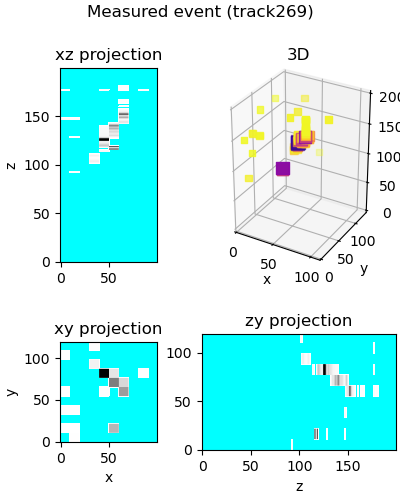

In [4]:
# View measured data

index = numpy.random.choice(DataLoader.nice_track_indices)
#index=135	# view chimney removal by setting preprocessed=False vs. True
#index=104
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot2DAnd3D(data_loader.getBatch(True,True,preprocessed=False)[index], "Measured event (track" + str(index+1) + ")")
fig.set_size_inches(4,5)
matplotlib.pyplot.show()

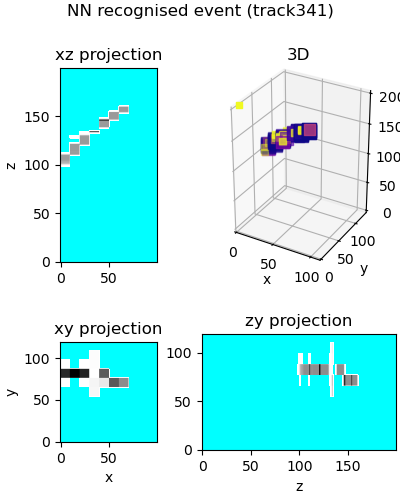

In [5]:
# Show reconstruction
index = numpy.random.choice(DataLoader.nice_track_indices)
#index=104

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = Plotting.plot2DAnd3D(X17_reconstructions[index-100], "NN recognised event (track" + str(index+1) + ")")
fig.set_size_inches(4,5)
matplotlib.pyplot.show()

In [6]:
# Set classification threshold tau

modelAPI.threshold = 0.42
X17_classified = modelAPI.classify(X17_reconstructions)

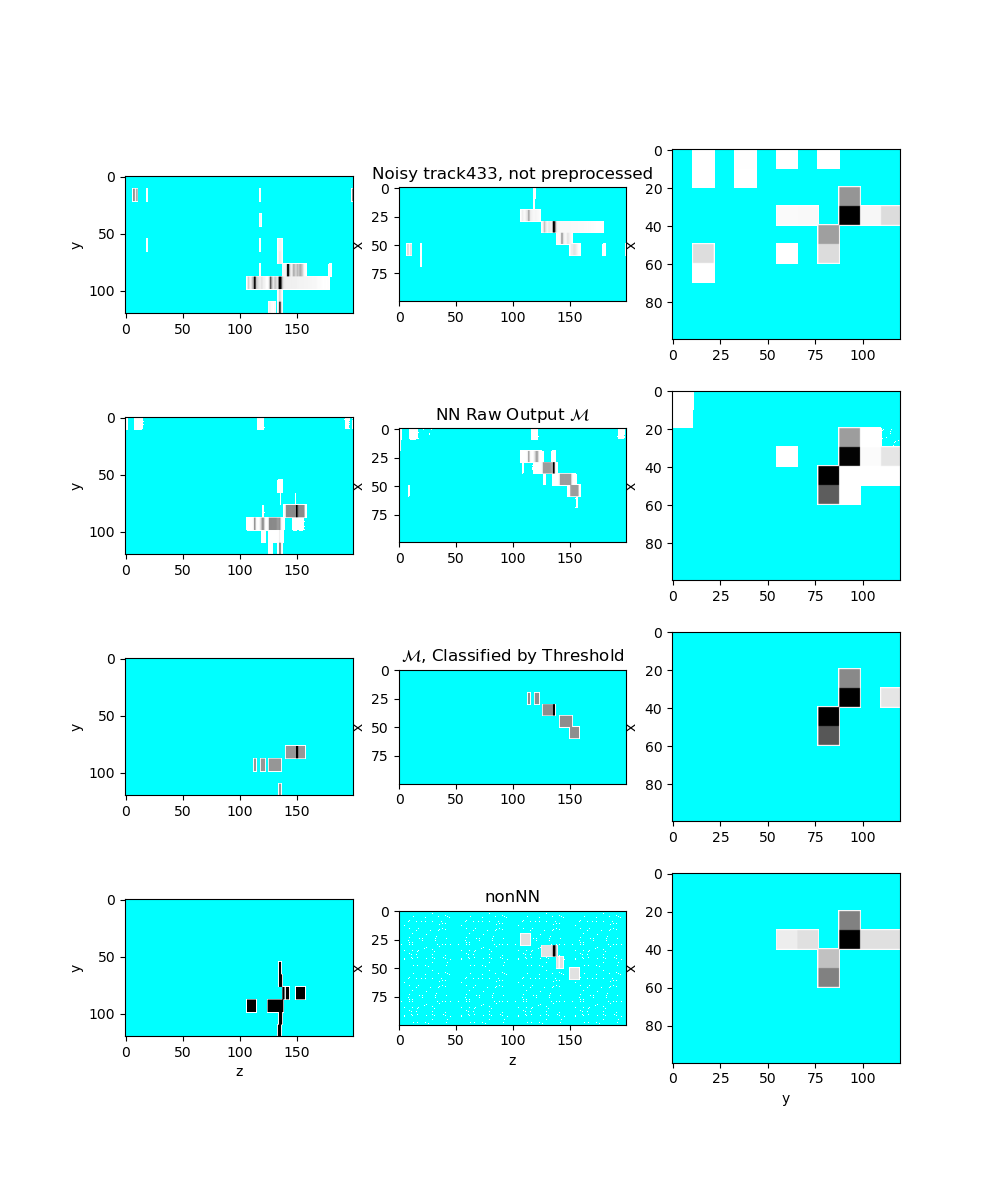

In [10]:
# View and compare reconstructions
#TODO in new plotting format

#index = numpy.random.randint(0, 642)
index = numpy.random.choice(DataLoader.nice_track_indices)
#index = 249
noisy_event = noisy_with_E[index]
#print(numpy.max(noisy_event))
preprocessed_event = noisy[index]
nonNN_reconstruction = numpy.where( clean[index] > 1e-6, 1, 0)
NN_raw_reconstruction = modelAPI.evaluateSingleEvent(preprocessed_event)
#NN_multiply_reconstruction = NN_raw_reconstruction * noisy_event
NN_classification = modelAPI.classify(NN_raw_reconstruction) 

def upsample(event):
	return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(4,3)
fig.set_size_inches(10, 12)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( noisy_event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(noisy_event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( NN_raw_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_raw_reconstruction)])/2)
	#ax[2,axis].imshow(numpy.sum(upsample( NN_multiply_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_multiply_reconstruction)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( NN_classification ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_classification)])/2)
	ax[3,axis].imshow(numpy.sum(upsample( nonNN_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(nonNN_reconstruction)])/2)

	for j in range(4):
		ax[j,axis].set_ylabel(proj_type[axis][1])
	ax[-1,axis].set_xlabel(proj_type[axis][0])

ax[0,1].set_title("Noisy " + names[index] + ", not preprocessed")
ax[1,1].set_title(r"NN Raw Output $\mathcal{M}$")
#ax[2,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$")
ax[2,1].set_title(r"$\mathcal{M}$, Classified by Threshold")
ax[3,1].set_title("nonNN")
matplotlib.pyplot.show()

In [22]:
# Compare recognition with ground truth

def parseGroundTruthLine(line :str) -> tuple[str, int]:
	index = line.find("	")
	name = line[:index-1]
	line = line[index+1:]
	label_hugo = int( line[:index] )
	return (name, label_hugo)

def compareGroundTruth(events :numpy.ndarray, goodCriterionFunction, skip_calibration :bool = True) -> tuple[int, list[int], list[int], list[int]]:
	num_tracks, found_tracks, unfound_tracks, false_positives = 0, [], [], []

	with open("./labels.txt", 'r') as f:
		f.readline()	# skip the heading

		if skip_calibration:
			for _ in range(100):
				f.readline()
		
		i = 0
		for line in f.readlines():
			name, label_hugo = parseGroundTruthLine(line)
			if goodCriterionFunction(events[i]):
				if label_hugo > 0:
					found_tracks.append(i)
					num_tracks += 1
				else:	
					false_positives.append(i)
			else:
				if label_hugo > 0:
					num_tracks += 1
					unfound_tracks.append(i)
			i += 1
	
	return num_tracks, found_tracks, unfound_tracks, false_positives

In [44]:
# Flagging compared with handmade labels

def isLabeledGood(event):
	# Pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(X17_classified, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

print("Number of tracks:", num_tracks)
print("nonNN: eff (true positives):", len(found_tracks_nonNN) / num_tracks, "   false positive rate:", len(false_positives_nonNN) / (len(false_positives_nonNN)+num_tracks))
print("NN: eff (true positives):", len(found_tracks_NN) / num_tracks, "   false positive rate:", len(false_positives_NN) / (len(false_positives_NN)+num_tracks))
print("NN did not found:", unfound_tracks_NN)
print("NN FPs:", false_positives_NN)

Number of tracks: 180
nonNN: eff (true positives): 1.0    false positive rate: 0.36619718309859156
NN: eff (true positives): 1.0    false positive rate: 0.29961089494163423
NN did not found: []
NN FPs: [2, 10, 22, 30, 43, 44, 51, 57, 61, 68, 69, 70, 78, 80, 88, 92, 97, 103, 110, 115, 116, 122, 125, 127, 133, 136, 137, 146, 152, 154, 156, 162, 165, 181, 185, 191, 205, 207, 214, 218, 229, 241, 244, 247, 255, 259, 278, 308, 309, 321, 334, 336, 337, 348, 358, 371, 382, 383, 389, 392, 401, 419, 430, 445, 451, 453, 458, 468, 478, 483, 498, 499, 506, 510, 511, 519, 530]


Smallest L2 distance threshold: 0.9850753768844221 (point (FPR, eff) = (0.1891891891891892, 0.9166666666666666) )
Best eff=1 threshold: 0.42366834170854273 (point (FPR, eff) = (0.29961089494163423, 1.0) )


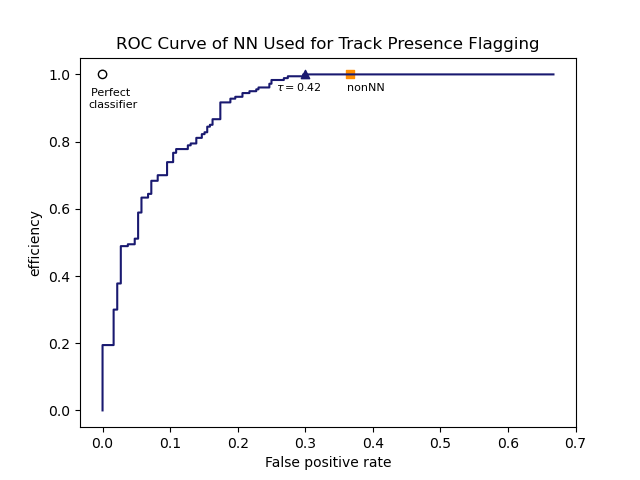

In [51]:
# ROC curve on validation dataset

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False


thresholds = numpy.concatenate( [numpy.linspace(0,0.01,200), numpy.linspace(0.01,0.99,200), numpy.linspace(0.99,1,200)] )
n = thresholds.shape[0]

# Count nonNN eff and FP and also NN eff and FP for individual classification thresholds
num_tracks, found_nonNN, _, FP_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)
num_found_nonNN , num_FP_nonNN= len(found_nonNN), len(FP_nonNN)
nums_found_NN, nums_FP_NN = [0]*n, [0]*n
for i in range(n):
	classified_events = numpy.where(X17_reconstructions > thresholds[i], 1, 0)
	_, found, _, FP = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
	nums_found_NN[i], nums_FP_NN[i] = len(found), len(FP)

NN_FPRs = [fp / (num_tracks + fp) for fp in nums_FP_NN]
nonNN_FPR = num_FP_nonNN / (num_tracks + num_FP_nonNN)
NN_effs = [num_found / num_tracks for num_found in nums_found_NN]
nonNN_eff = num_found_nonNN / num_tracks


# Threshold closest to (0,1)
def distance(fp, eff):
	return fp**2 + (eff-1)**2	#L2

optimal_threshold, best_dist, optimal_index = -1, numpy.infty, -1
for j in range(n):
	dist = distance(NN_FPRs[j], NN_effs[j])
	if dist < best_dist:
		optimal_index = j
		optimal_threshold = thresholds[j]
		best_dist = dist
print("Smallest L2 distance threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[optimal_index]) + ", " + str(NN_effs[optimal_index]) + ") )")

# First threshold with efficiency one
optimal_threshold = -1
for j in range(n-1,-1,-1):
	if NN_effs[j] == 1:
		optimal_threshold = thresholds[j]
		break
print("Best eff=1 threshold:", optimal_threshold, "(point (FPR, eff) = (" + str(NN_FPRs[j]) + ", " + str(NN_effs[j]) + ") )")


# Plot ROC
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
ax.plot(NN_FPRs, NN_effs, color="midnightblue", drawstyle="steps-post")
ax.scatter([nonNN_FPR], [nonNN_eff], marker="s" , color="darkorange")
ax.annotate("nonNN", (nonNN_FPR, nonNN_eff), xytext=(nonNN_FPR-0.005, nonNN_eff-0.05), fontsize=8)	# nonNN
ax.scatter([NN_FPRs[j]], [NN_effs[j]], marker="^", color="midnightblue")
ax.annotate(r"$\tau = 0.42$", (NN_FPRs[j], NN_effs[j]), xytext=(NN_FPRs[j]-0.043, NN_effs[j]-0.05), fontsize=8)	# eff=1
ax.scatter([0], [1], marker="o", facecolors="none", color="black")
ax.annotate("Perfect \nclassifier", (0, 1), xytext=(0.015, 1-0.1), fontsize=8, horizontalalignment="center")	# perfect classifier
ax.set_xlabel("False positive rate")
ax.set_ylabel("efficiency")
ax.set_title("ROC Curve of NN Used for Track Presence Flagging")
matplotlib.pyplot.show()

#fig.savefig("./imgs/paper/ROC_hugoFP.pdf")

In [59]:
# Flagging intersections

def isLabeledGood(event):
	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

threshold = 0.42

N = X17_reconstructions.shape[0]
classified_events = numpy.where(X17_reconstructions > threshold, 1, 0)
num_tracks, found_tracks_NN, unfound_tracks_NN, false_positives_NN = compareGroundTruth(classified_events, isLabeledGood, skip_calibration=True)
_, found_tracks_nonNN, unfound_tracks_nonNN, false_positives_nonNN = compareGroundTruth(X17_nonNN, isLabeledGood, skip_calibration=True)

def getIntersection(NN, nonNN, use_tracks):
	ls_NN = found_tracks_NN if use_tracks else false_positives_NN
	ls_nonNN = found_tracks_nonNN if use_tracks else false_positives_nonNN
	return [j for j in range(N) if ( (NN and j in ls_NN) or (not NN and j not in ls_NN) )
			and ( (nonNN and j in ls_nonNN) or (not nonNN and j not in ls_nonNN) )]

print("NN & nonNN IN FOUND TRACKS:", len(getIntersection(True, True, True)))
print("NN & nonNN IN FPS:", len(getIntersection(True,True,False)))
print("NN & NOT nonNN IN FPS:", len(getIntersection(True,False,False)))
print("NOT NN & nonNN IN FPS:", len(getIntersection(False,True,False)))
print("NOT NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(False,False,True)))
print("NN & NOT nonNN IN FOUND TRACKS:", len(getIntersection(True,False,True)))
print("NOT NN & nonNN IN FOUND TRACKS:", len(getIntersection(False,True,True)))
print("NOT NN & NOT nonNN IN FPS:", len(getIntersection(False,False,False)))
print("Eff:",len(found_tracks_NN)/num_tracks)
print("FP:",len(false_positives_NN)/(len(false_positives_NN) + num_tracks))

NN & nonNN IN FOUND TRACKS: 180
NN & nonNN IN FPS: 71
NN & NOT nonNN IN FPS: 6
NOT NN & nonNN IN FPS: 33
NOT NN & NOT nonNN IN FOUND TRACKS: 361
NN & NOT nonNN IN FOUND TRACKS: 0
NOT NN & nonNN IN FOUND TRACKS: 0
NOT NN & NOT nonNN IN FPS: 431
Eff: 1.0
FP: 0.29961089494163423


Tile number: 40
Ratio of tiles on line fit: 0.825
Average distance from line fit: 0.5104338454178058
Missing tiles: 20


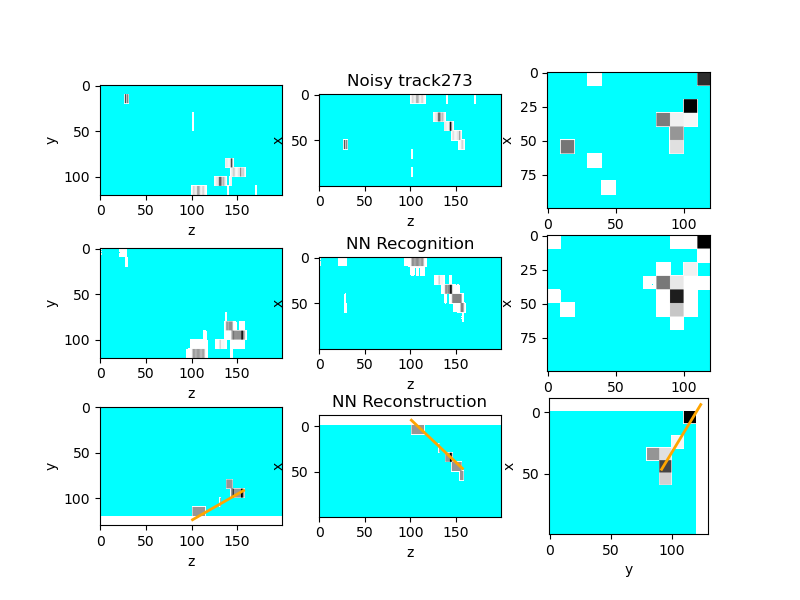

In [63]:
# Line fit analysis example
modelAPI.threshold = 0.42

index = numpy.random.choice(data_loader.nice_track_indices)
#index = numpy.random.randint(0,641)
#index=609
event = data_loader.getBatch(True,True)[index]
rec = modelAPI.evaluateSingleEvent(event)
result = modelAPI.classify(rec)
name = data_loader.getX17Names()[index]
in_temporal_space = False	# Whether fitting happens in (x,y,t) or (x,y,z)

lin_fit = LinearFit(result, in_temporal_space)

outliers = lin_fit.getOutliers()
mean_residuum = lin_fit.getMeanResiduum()
missing_tiles = lin_fit.getMissingTiles(event, in_temporal_space)

print("Tile number:", len(lin_fit.coords))
print("Ratio of tiles on line fit:", 1 - len(outliers)/len(lin_fit.coords))
print("Average distance from line fit:", mean_residuum)
print("Missing tiles:", len(missing_tiles))

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(3,3)
fig.set_size_inches(8, 6)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]
proj_indices = [(2,1), (2,0), (1,0)]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( rec ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(rec)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( result ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(result)])/2)
	a, b = (10*lin_fit.start[0], 11*lin_fit.start[1], (1 if in_temporal_space else 10)*lin_fit.start[2]), (10*lin_fit.end[0], 11*lin_fit.end[1], (1 if in_temporal_space else 10)*lin_fit.end[2])
	k, l = proj_indices[axis][0], proj_indices[axis][1]
	ax[2,axis].plot( [a[k], b[k]], [a[l], b[l]], linewidth=2, color="orange" )

	for j in range(3):
		ax[j,axis].set_ylabel(proj_type[axis][1])
		ax[j,axis].set_xlabel(proj_type[axis][0])

ax[0,1].set_title("Noisy " + name)
ax[1,1].set_title("NN Recognition")
ax[2,1].set_title("NN Reconstruction")

matplotlib.pyplot.show()

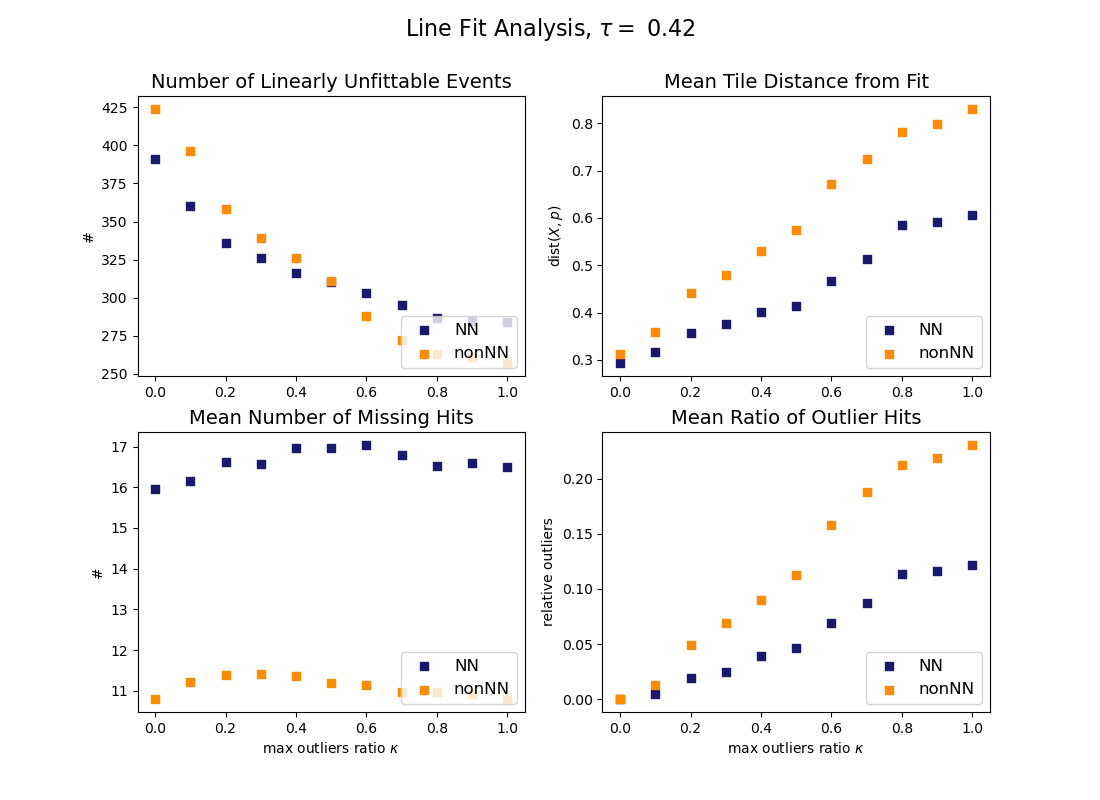

In [33]:
# Line fit analysis for variable kappa (max ratio of outliers)

modelAPI.threshold = 0.42
thresholds_outliers = numpy.linspace(0, 1, 11)
in_temporal_space = False

def isLabeledGood(event):
	#return numpy.any(event > 0)	# Just that there is something left in the event

	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

fittable_NNs, fittable_nonNNs = [None]*X17_classified.shape[0], [None]*X17_classified.shape[0]

final_NN_outliers, final_nonNN_outliers = [], []
final_NN_residuum, final_nonNN_residuum = [], []
final_NN_missing, final_nonNN_missing = [], []
final_NN_counts, final_nonNN_counts = [], []

for threshold_outliers in thresholds_outliers:
	NN_outliers, nonNN_outliers = [], []
	NN_residuum, nonNN_residuum = [], []
	NN_total_tile_num, nonNN_total_tile_num = 0, 0
	NN_missing_tiles, nonNN_missing_tiles = [], []

	NN_final_count, nonNN_final_count, final_data_indices = 0, 0, []
	for i in range(641):
		i -= 100
		if i < 0:	continue
		noisy_event, NN_event, nonNN_event = X17_noisy[i], modelAPI.classify(X17_reconstructions[i]), X17_nonNN[i]
		#if numpy.sum(NN_event) == 0 or numpy.sum(nonNN_event) == 0:	continue
		
		if not isLabeledGood(nonNN_event):
			nonNN_final_count += 1	# We count unfittable events
		else:
			lin_fit = LinearFit(nonNN_event, in_temporal_space)
			ratio_outliers_nonNN = len( lin_fit.getOutliers() ) / len(lin_fit.coords)
			if ratio_outliers_nonNN <= threshold_outliers:
				fittable_nonNNs[i] = nonNN_event
			else:
				nonNN_final_count += 1
		
		'''temp = numpy.copy(X17_noisy_with_E[i])
		removeChimneys(temp)
		NN_event = numpy.where(temp > 0, NN_event, 0)'''
		
		if not isLabeledGood(NN_event):
			NN_final_count += 1
		else:
			lin_fit = LinearFit(NN_event, in_temporal_space)
			ratio_outliers_NN = len( lin_fit.getOutliers() ) / len(lin_fit.coords)
			if ratio_outliers_NN <= threshold_outliers:
				fittable_NNs[i] = NN_event
			else:
				NN_final_count += 1
		
		if fittable_nonNNs[i] is not None and fittable_NNs[i] is not None:
			final_data_indices.append(i)

	final_NN_counts.append(NN_final_count)
	final_nonNN_counts.append(nonNN_final_count)

	for i in final_data_indices:
		noisy_event, NN_event, nonNN_event = X17_noisy[i], modelAPI.classify(X17_reconstructions[i]), X17_nonNN[i]
		#if numpy.sum(NN_event) == 0 or numpy.sum(nonNN_event) == 0:	continue
		
		lin_fit = LinearFit(NN_event, in_temporal_space)
		NN_outliers.append( len( lin_fit.getOutliers() ) / len(lin_fit.coords) )
		NN_residuum.append( lin_fit.getTotalResiduum() )
		NN_total_tile_num += len(lin_fit.coords)
		NN_missing_tiles.append( len(lin_fit.getMissingTiles(noisy_event, in_temporal_space=in_temporal_space)) )

		lin_fit = LinearFit(nonNN_event, in_temporal_space=in_temporal_space)
		nonNN_outliers.append( len( lin_fit.getOutliers() ) / len(lin_fit.coords) )
		nonNN_residuum.append( lin_fit.getTotalResiduum() )
		nonNN_total_tile_num += len(lin_fit.coords)
		nonNN_missing_tiles.append( len(lin_fit.getMissingTiles(noisy_event, in_temporal_space=in_temporal_space)) )

	final_NN_outliers.append( numpy.mean(NN_outliers) )
	final_nonNN_outliers.append( numpy.mean(nonNN_outliers) )
	final_NN_residuum.append( numpy.sum(NN_residuum) / NN_total_tile_num )
	final_nonNN_residuum.append( numpy.sum(nonNN_residuum) / nonNN_total_tile_num )
	final_NN_missing.append( numpy.mean(NN_missing_tiles) )
	final_nonNN_missing.append( numpy.mean(nonNN_missing_tiles) )

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(2,2)
fig.set_size_inches(11, 8)
#fig.tight_layout()

fig.suptitle(r"Line Fit Analysis, $\tau =$ " + str(modelAPI.threshold), fontsize=16)

ax[0,0].scatter(thresholds_outliers, final_NN_counts, label="NN", color="midnightblue", marker="s")
ax[0,0].scatter(thresholds_outliers, final_nonNN_counts, label="nonNN", color="darkorange", marker="s")
ax[0,0].legend(prop={'size': 12}, loc="lower right")
ax[0,0].set_title("Number of Linearly Unfittable Events", fontdict={"fontsize": 14})

ax[0,1].scatter(thresholds_outliers, final_NN_residuum, label="NN", color="midnightblue", marker="s")
ax[0,1].scatter(thresholds_outliers, final_nonNN_residuum, label="nonNN", color="darkorange", marker="s")
ax[0,1].legend(prop={'size': 12}, loc="lower right")
ax[0,1].set_title("Mean Tile Distance from Fit", fontdict={"fontsize": 14})

ax[1,0].scatter(thresholds_outliers, final_NN_missing, label="NN", color="midnightblue", marker="s")
ax[1,0].scatter(thresholds_outliers, final_nonNN_missing, label="nonNN", color="darkorange", marker="s")
ax[1,0].legend(prop={'size': 12}, loc="lower right")
ax[1,0].set_title("Mean Number of Missing Hits", fontdict={"fontsize": 14})

ax[1,1].scatter(thresholds_outliers, final_NN_outliers, label="NN", color="midnightblue", marker="s")
ax[1,1].scatter(thresholds_outliers, final_nonNN_outliers, label="nonNN", color="darkorange", marker="s")
ax[1,1].legend(prop={'size': 12}, loc="lower right")
ax[1,1].set_title("Mean Ratio of Outlier Hits", fontdict={"fontsize": 14})

ax[1,0].set_xlabel(r"max outliers ratio $\kappa$")
ax[1,1].set_xlabel(r"max outliers ratio $\kappa$")

ax[0,0].set_ylabel("#")
ax[0,1].set_ylabel(r"$\text{dist}(X,p)$")
ax[1,0].set_ylabel("#")
ax[1,1].set_ylabel("relative outliers")

matplotlib.pyplot.show()
#fig.savefig("imgs/paper/linear_analysis_tau0.1.pdf")

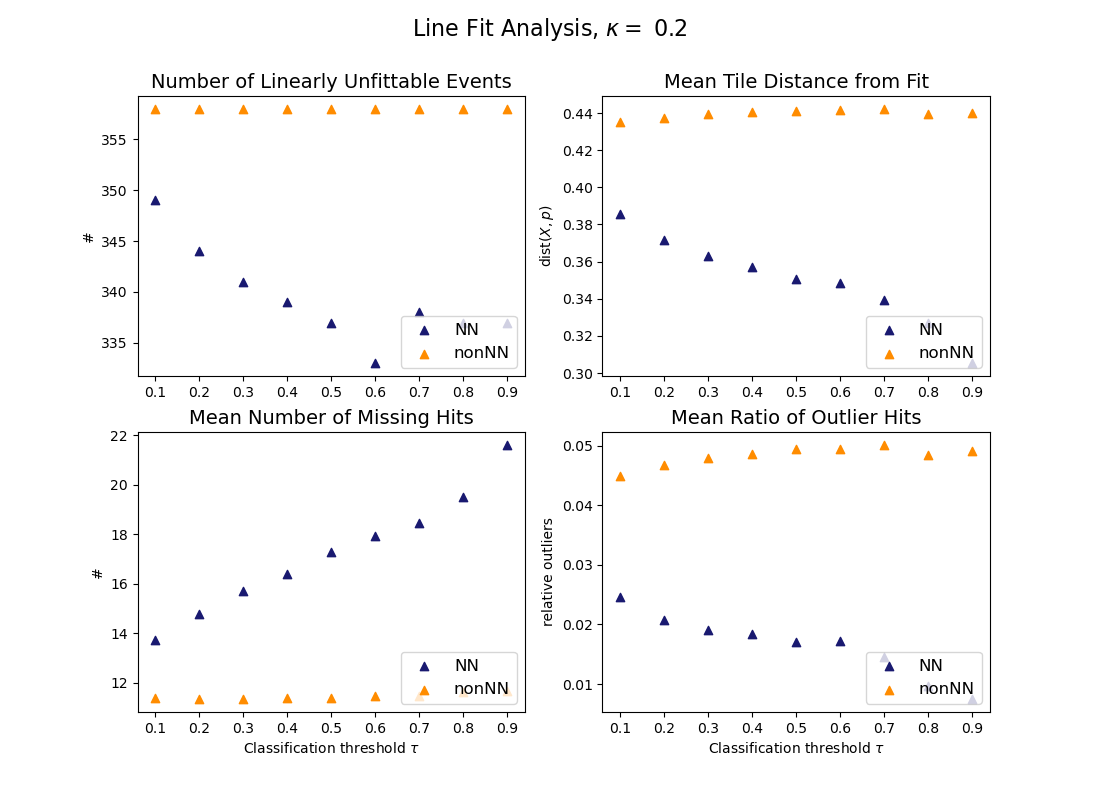

In [34]:
# Line fit analysis for variable tau (classification threshold)

threshold_outliers = 0.2
in_temporal_space = False

def isLabeledGood(event):
	#return numpy.any(event > 0)	# Just that there is something left in the event

	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

thresholds = numpy.linspace(0.1, 0.9, 9)

final_NN_outliers, final_nonNN_outliers = [], []
final_NN_residuum, final_nonNN_residuum = [], []
final_NN_missing, final_nonNN_missing = [], []
final_NN_counts, final_nonNN_counts = [], []

for tau in thresholds:
	modelAPI.threshold = tau
	NN_outliers, nonNN_outliers = [], []
	NN_residuum, nonNN_residuum = [], []
	NN_total_tile_num, nonNN_total_tile_num = 0, 0
	NN_missing_tiles, nonNN_missing_tiles = [], []

	NN_final_count, nonNN_final_count, final_data_indices = 0, 0, []
	for i in range(641):
		i -= 100
		if i < 0:	continue
		noisy_event, NN_event, nonNN_event = X17_noisy[i], modelAPI.classify(X17_reconstructions[i]), X17_nonNN[i]

		#if numpy.sum(NN_event) == 0 or numpy.sum(nonNN_event) == 0:	continue

		if not isLabeledGood(nonNN_event):
			nonNN_final_count += 1
		else:
			lin_fit = LinearFit(nonNN_event, in_temporal_space)
			ratio_outliers_nonNN = len( lin_fit.getOutliers() ) / len(lin_fit.coords)
			if ratio_outliers_nonNN > threshold_outliers:
				nonNN_final_count += 1

		'''temp = numpy.copy(X17_noisy_with_E[i])
		removeChimneys(temp)
		NN_event = numpy.where(temp > 0, NN_event, 0)'''

		if not isLabeledGood(NN_event):
			NN_final_count += 1
		else:
			lin_fit = LinearFit(NN_event, in_temporal_space)
			ratio_outliers_NN = len( lin_fit.getOutliers() ) / len(lin_fit.coords)
			if ratio_outliers_NN > threshold_outliers:
				NN_final_count += 1
		
		if ratio_outliers_NN <= threshold_outliers and ratio_outliers_nonNN <= threshold_outliers:
			final_data_indices.append(i)

	final_NN_counts.append(NN_final_count)
	final_nonNN_counts.append(nonNN_final_count)

	for i in final_data_indices:
		noisy_event, NN_event, nonNN_event = X17_noisy[i], modelAPI.classify(X17_reconstructions[i]), X17_nonNN[i]
		if numpy.sum(NN_event) == 0 or numpy.sum(nonNN_event) == 0:	continue
		lin_fit = LinearFit(NN_event, in_temporal_space)
		NN_outliers.append( len( lin_fit.getOutliers() ) / len(lin_fit.coords) )
		NN_residuum.append( lin_fit.getTotalResiduum() )
		NN_total_tile_num += len(lin_fit.coords)
		NN_missing_tiles.append( len(lin_fit.getMissingTiles(noisy_event, in_temporal_space)) )

		lin_fit = LinearFit(nonNN_event, in_temporal_space)
		nonNN_outliers.append( len( lin_fit.getOutliers() ) / len(lin_fit.coords) )
		nonNN_residuum.append( lin_fit.getTotalResiduum() )
		nonNN_total_tile_num += len(lin_fit.coords)
		nonNN_missing_tiles.append( len(lin_fit.getMissingTiles(noisy_event, in_temporal_space)) )

	final_NN_outliers.append( numpy.mean(NN_outliers) )
	final_nonNN_outliers.append( numpy.mean(nonNN_outliers) )
	final_NN_residuum.append( numpy.sum(NN_residuum) / NN_total_tile_num )
	final_nonNN_residuum.append( numpy.sum(nonNN_residuum) / nonNN_total_tile_num )
	final_NN_missing.append( numpy.mean(NN_missing_tiles) )
	final_nonNN_missing.append( numpy.mean(nonNN_missing_tiles) )

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(2,2)
fig.set_size_inches(11, 8)
#fig.tight_layout()

fig.suptitle(r"Line Fit Analysis, $\kappa =$ " + str(threshold_outliers), fontsize=16)

ax[0,0].scatter(thresholds, final_NN_counts, label="NN", color="midnightblue", marker="^")
ax[0,0].scatter(thresholds, final_nonNN_counts, label="nonNN", color="darkorange", marker="^")
ax[0,0].legend(prop={'size': 12}, loc="lower right")
ax[0,0].set_title("Number of Linearly Unfittable Events", fontdict={"fontsize": 14})

ax[0,1].scatter(thresholds, final_NN_residuum, label="NN", color="midnightblue", marker="^")
ax[0,1].scatter(thresholds, final_nonNN_residuum, label="nonNN", color="darkorange", marker="^")
ax[0,1].legend(prop={'size': 12}, loc="lower right")
ax[0,1].set_title("Mean Tile Distance from Fit", fontdict={"fontsize": 14})

ax[1,0].scatter(thresholds, final_NN_missing, label="NN", color="midnightblue", marker="^")
ax[1,0].scatter(thresholds, final_nonNN_missing, label="nonNN", color="darkorange", marker="^")
ax[1,0].legend(prop={'size': 12}, loc="lower right")
ax[1,0].set_title("Mean Number of Missing Hits", fontdict={"fontsize": 14})

ax[1,1].scatter(thresholds, final_NN_outliers, label="NN", color="midnightblue", marker="^")
ax[1,1].scatter(thresholds, final_nonNN_outliers, label="nonNN", color="darkorange", marker="^")
ax[1,1].legend(prop={'size': 12}, loc="lower right")
ax[1,1].set_title("Mean Ratio of Outlier Hits", fontdict={"fontsize": 14})

ax[1,0].set_xlabel(r"Classification threshold $\tau$")
ax[1,1].set_xlabel(r"Classification threshold $\tau$")

ax[0,0].set_ylabel("#")
ax[0,1].set_ylabel(r"$\text{dist}(X,p)$")
ax[1,0].set_ylabel("#")
ax[1,1].set_ylabel("relative outliers")

matplotlib.pyplot.show()
#fig.savefig("imgs/paper/linear_analysis_kappa0.2.pdf")

/home/gajdoma6/UTEF/track_denoiser/classes/clusterClass.py:197: RuntimeWarning: invalid value encountered in double_scalars
  self.energy_density = self.energy / self.effective_length
/tmp/ipykernel_13909/227121875.py:89: RuntimeWarning: invalid value encountered in double_scalars
  energy_densities.append(E / cluster.effective_length)


[255.71784976920904, 259.4429153387953, 410.0950695895952, 456.99040808753807, 613.3089518897838, 261.81130657641233, 512.15689997239, 459.42857142857144, 432.99467959591817, 596.3738592527342, 385.6916380317016, 592.0745720351237, 89.93156602197128, 229.11839984887143, 548.0305873884463, 188.93425412283602, 279.33452664820686, 626.7282010571303, 294.1092231736208, 482.1333333333333, 154.64102916145347, 184.3723067678647, 296.3976176277716, 295.163514005373, 545.0787408240667, 170.0254775868881, nan, 62.58146730018207, 382.7552063494579, 496.6085129211341, 163.46901127448842, 341.6279069767442, 350.7426888617272, 396.1940262261046, 200.94019205801942, 188.2032169907525, 270.7159245431311, 237.88960510153532, 453.4939857725192, 272.47331415079094, 155.51570051220568, 27.216552697590867, 346.77755548698326, 316.5145253526397, 131.21177314465615, 303.00980006891155, 220.00098778218208, 142.42832438179877, 427.5078009595914, 467.65609828247784, 314.7023930463196, 195.27658892492133, 300.98

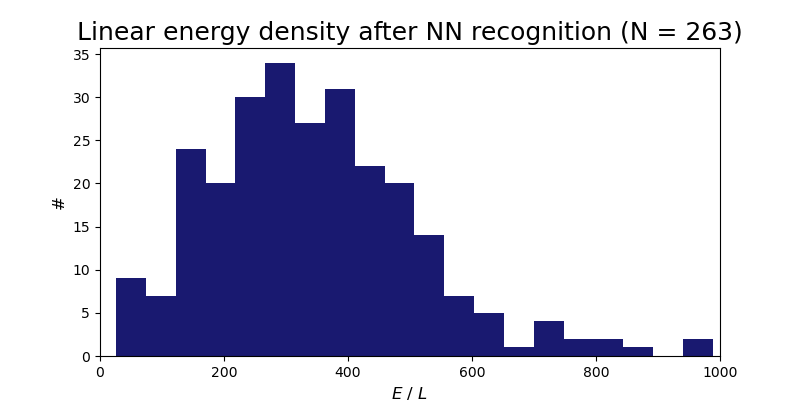

In [35]:
#Four reconstruction energy histograms
#TODO try this on the good ones from linear analysis

import scipy
modelAPI.threshold = 0.42 #0.42 #0.005959224999999999	# Found in previous step
X17_classified = modelAPI.classify(X17_reconstructions)


'''X17_NN_lin = []
	for i in data_loader.nice_track_indices:
		i -= 100
		if i < 0:	continue
		noisy_event, NN_event, nonNN_event = X17_noisy[i], modelAPI.classify(X17_reconstructions[i]), X17_nonNN[i]

		coords, line_start, line_end, line_mean, line_direction = prepareLineFit(nonNN_event, in_temporal_space)
		ratio_outliers_nonNN = len( getOutliers(coords, line_mean, line_direction) ) / len(coords)
		if ratio_outliers_nonNN <= threshold_outliers:
			nonNN_final_count += 1

		if numpy.sum(NN_event) == 0:	continue	# For larger thresholds, we lose some of the tracks (eff < 1)

		coords, line_start, line_end, line_mean, line_direction = prepareLineFit(NN_event, in_temporal_space)
		ratio_outliers_NN = len( getOutliers(coords, line_mean, line_direction) ) / len(coords)
		if ratio_outliers_NN <= threshold_outliers:
			NN_final_count += 1
		
		if ratio_outliers_NN <= threshold_outliers and ratio_outliers_nonNN <= threshold_outliers:
			final_data_indices.append(i)'''

def fitFunction(x, a, b, N):
	y = a*x+b
	return N*numpy.exp(-0.5*(y+numpy.exp(-y)))


def isLabeledGood(event):
	#return numpy.any(event > 0)	# Just that there is something left in the event

	# At least pad screen
	if numpy.any(event > 0):
		xs, ys, zs = numpy.nonzero(event)
		visited_pads = {}
		for i in range(xs.shape[0]):
			visited_pads[(xs[i], ys[i])] = 1
		if len(visited_pads) >= 2 or len(zs) >= 20:	return True
	return False

def getEnergies(track_events, energy_events, make_clusters=False, eventCondition = lambda x: True, clusterCondition = lambda x: True):
	energy_densities = []

	for i in range(track_events.shape[0]):
		event = track_events[i]
		event_E = energy_events[i]
		if not eventCondition(event):	continue

		xs, ys, zs = numpy.nonzero(event)
		if len(xs) == 0:	continue

		# with line fit
		'''coords, start, end, mean, direction = prepareLineFit(event)
		colin = getColinearTiles(coords, mean, direction)
		E = 0
		for coord in colin:
			E += event_E[coord]
		energy_densities.append(E / numpy.sqrt( (end[0]-start[0])**2 + (end[1]-start[1])**2 + (end[2]-start[2])**2 / 10**2 ))'''

		# without line fit
		if make_clusters:
			for cluster in Cluster.clusterise(event):
				if clusterCondition(cluster):
					cluster.setEnergy(event_E)
					#energy_densities.append(cluster.energy_density)
					pads_E = {}
					for coord in cluster.coords:
						if coord[:2] not in pads_E or pads_E[coord[:2]] < event_E[coord]:
							pads_E[coord[:2]] = event_E[coord]
					E = sum(pads_E[pad] for pad in pads_E)
					energy_densities.append(E / cluster.effective_length)
		else:
			coords = ( list(xs), list(ys), list(zs) )
			coords = list(zip(*coords))
			cluster = Cluster(coords)
			cluster.setEnergy(event_E)
			#energy_densities.append(cluster.energy_density)
			pads_E = {}
			for coord in cluster.coords:
				if coord[:2] not in pads_E or pads_E[coord[:2]] < event_E[coord]:
					pads_E[coord[:2]] = event_E[coord]
			E = sum(pads_E[pad] for pad in pads_E)
			energy_densities.append(E / cluster.effective_length)

	return energy_densities


# We don't want to apply E/L cut here
#Cluster.min_energy_density = 0

energies_noisy = getEnergies(X17_noisy, X17_noisy_with_E, make_clusters=False, clusterCondition=lambda x: len(x.coords) >= 0)
energies_nonNN = getEnergies(X17_nonNN, X17_noisy_with_E, make_clusters=False, clusterCondition=lambda x: len(x.coords) >= 0)
energies_NN = getEnergies(X17_classified, X17_noisy_with_E, make_clusters=False, clusterCondition=lambda x: len(x.coords) >= 0)
energies = [energies_noisy, energies_NN, energies_nonNN]
titles = ["Linear energy density for noisy measured events", "Linear energy density after NN recognition (N = 263)", "Linear energy density after nonNN recognition"]

print(energies_NN)
print(len(energies_NN))
print(min(energies_NN))
print(max(energies_NN))
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(1)
fig.set_size_inches(8, 4)
#fig.tight_layout()

j=1
counts, bins, _ = ax.hist(energies[j], bins=20, histtype="stepfilled", color="midnightblue", label="Data")
ax.set_xlim(0,1000)
ax.set_ylabel("#", fontsize=12)
ax.set_title(titles[j], fontsize=18)
ax.set_xlabel(r"$E$ / $L$", fontsize=12)

centres = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
params, _ = scipy.optimize.curve_fit(fitFunction, centres, counts, p0=(1/100,-1,30))

#xs = [i for i in range(1000)]
#ys = [fitFunction(x,*params) for x in xs]
#ax.plot(xs, ys, color="darkorange", label="Landau fit")
#ax.legend()

xs = [i for i in range(900)]
ys = []
fit_landau_f = open("landau.txt", "r")
for line in fit_landau_f.readlines():
	ys.append(float(line))

#ax.plot(xs, ys, color="darkorange", label="Landau fit")
#ax.legend()

matplotlib.pyplot.show()
fig.savefig("imgs/paper/E_L_NN_nofit.pdf")



In [ ]:
# Screening, whole events

Cluster.active_zone_threshold = 0.7
Cluster.min_energy_density = 90
Cluster.min_length = 3
Cluster.max_nonlinearity = 2
Cluster.max_neighbour_coef = 5

def screen(track_data, energy_data):
	screen_results = []

	for i in range(track_data.shape[0]):
		xs, ys, zs = numpy.nonzero(track_data[i])
		if len(xs) == 0:
			screen_results.append(False)
			continue
		coords = ( list(xs), list(ys), list(zs) )
		coords = list(zip(*coords))

		cluster = Cluster(coords)
		score = 0
		if cluster.pad_length >= Cluster.min_length:
			score += 1
		
		cluster.setEnergy(energy_data[i])
		if cluster.energy_density >= Cluster.min_energy_density:
			score += 1
		
		if cluster.neighbour_coef <= Cluster.max_neighbour_coef:
			score += 1

		'''line_start, line_end, line_mean, line_direction = fitLinePCA(cluster)
		total_residuum = getTotalNonlinearityResiduum(cluster, line_direction, line_mean)
		cluster.nonlinearity = total_residuum / cluster.num_tiles
		if total_residuum / cluster.num_tiles <= Cluster.max_nonlinearity:
			score += 1'''

		screen_results.append(score >= 3)
	return screen_results

nonNN_is_track, NN_is_track = screen(X17_nonNN, X17_noisy_with_E), screen(X17_classified, X17_noisy_with_E)

screening_NN, screening_nonNN = numpy.zeros((len(X17_names),12,14,208)), numpy.zeros((len(X17_names),12,14,208))
for i in range(len(X17_names)):
	if NN_is_track[i]:	screening_NN[i] = X17_classified[i]
	if nonNN_is_track[i]:	screening_nonNN[i] = X17_classified[i]

AttributeError: 'Cluster' object has no attribute 'neighbour_coef'